In [1]:
import torch
import torchvision

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

## Data

In [3]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.ToTensor()
])

In [25]:
mnist_train = torchvision.datasets.MNIST('data/', transform=transform, train=True)
mnist_test = torchvision.datasets.MNIST('data/', transform=transform, train=False)

In [34]:
mnist_train_x = mnist_train.train_data
mnist_train_y = mnist_train.train_labels
mnist_test_x = mnist_test.test_data
mnist_test_y = mnist_test.test_labels

/Users/sebastianlee/Envs/meta/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/Users/sebastianlee/Envs/meta/lib/python3.7/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [35]:
def get_data():

    binary_mnist_0 = [(torch.flatten(x).type(torch.FloatTensor), torch.Tensor([0]).type(torch.LongTensor)) for (i, x) in enumerate(mnist_train_x) if mnist_train_y[i] == 0]
    binary_mnist_1 = [(torch.flatten(x).type(torch.FloatTensor), torch.Tensor([1]).type(torch.LongTensor)) for (i, x) in enumerate(mnist_train_x) if mnist_train_y[i] == 1]

    binary_mnist = binary_mnist_0 + binary_mnist_1
    random.shuffle(binary_mnist)

    binary_mnist_x = [d[0] for d in binary_mnist]
    binary_mnist_y = [d[1] for d in binary_mnist]
    
    return binary_mnist_x, binary_mnist_y

In [36]:
def get_test_data():
    
    binary_mnist_0 = [(torch.flatten(x).type(torch.FloatTensor), torch.Tensor([0]).type(torch.LongTensor)) for (i, x) in enumerate(mnist_test_x) if mnist_test_y[i] == 0]
    binary_mnist_1 = [(torch.flatten(x).type(torch.FloatTensor), torch.Tensor([1]).type(torch.LongTensor)) for (i, x) in enumerate(mnist_test_x) if mnist_test_y[i] == 1]

    binary_mnist = binary_mnist_0 + binary_mnist_1
    random.shuffle(binary_mnist)

    binary_mnist_x = torch.stack([d[0] for d in binary_mnist])
    binary_mnist_y = torch.flatten(torch.Tensor([d[1] for d in binary_mnist]))
    
    return binary_mnist_x, binary_mnist_y

In [65]:
d_trial = get_data()

In [69]:
print(len(d_trial[0]))

12665


In [39]:
print(td[0].shape, td[1].shape)

torch.Size([2115, 784]) torch.Size([2115])


/Users/sebastianlee/Envs/meta/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


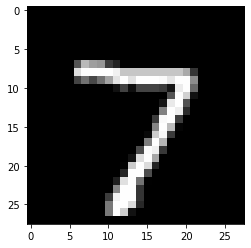

In [8]:
fig = plt.figure()
plt.imshow(mnist_train_x[0].numpy(), cmap='gray')
fig.show()

In [9]:
def plot_instance(i):
    fig = plt.figure()
    plt.imshow(binary_mnist_x[i].reshape((28, 28)))
    plt.title("Example of {}".format(binary_mnist_y[i]))
    fig.show()

## Model

In [10]:
class MNISTModel(torch.nn.Module):
    
    def __init__(self):
        
        super(MNISTModel, self).__init__()
        
        self.fc1 = torch.nn.Linear(784, 1024)
        self.fc2 = torch.nn.Linear(1024, 784)
        self.fc3 = torch.nn.Linear(784, 256)
        self.fc4 = torch.nn.Linear(256, 64)
        self.fc5 = torch.nn.Linear(64, 2)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = torch.nn.functional.relu(self.fc4(x))
        y = self.fc5(x)
        
        return y
    

In [76]:
class MNISTTrainer:
    
    def __init__(self, num_epochs, lr):
        
        self.model = MNISTModel()
        self.loss_fn = torch.nn.CrossEntropyLoss()
        
        self.num_epochs = num_epochs
        self.lr = lr
        
        self.optimiser = torch.optim.SGD(self.model.parameters(), lr = self.lr)
        self.losses = []
        self.accuracies = []
        
        self.test_data = get_test_data()
        
    def train(self):
        for e in range(self.num_epochs):
            
            i = 0
            
            x_data, y_data = get_data()
            
            assert(len(x_data) == len(y_data))
            
            while len(x_data) != 0:
                
                x = x_data.pop()
                x = x.unsqueeze(0)
                
                y = y_data.pop()
                
                yhat = self.model(x)
                
                self.optimiser.zero_grad()
                loss = self.loss_fn(yhat, y)
                loss.backward()
                self.optimiser.step()
            
                self.losses.append(float(loss))
                
                if i % 100 == 0:
                
                    test_forward = self.model(self.test_data[0]).detach().numpy()
                    test_yhat = np.argmax(test_forward, axis=1)
                    acc = sum(test_yhat == self.test_data[1].numpy()) / len(self.test_data[1])

                    print("accuracy at time step {}: {}".format(i, acc))
                    
                    self.accuracies.append(acc)
                
                i += 1
                
                

In [77]:
trainer = MNISTTrainer(1, 0.001)

In [78]:
trainer.train()

accuracy at time step 0: 0.46335697399527187
accuracy at time step 100: 0.9971631205673759
accuracy at time step 200: 0.9981087470449173
accuracy at time step 300: 0.9976359338061466
accuracy at time step 400: 0.9971631205673759
accuracy at time step 500: 0.9895981087470449
accuracy at time step 600: 0.9981087470449173
accuracy at time step 700: 0.9990543735224586
accuracy at time step 800: 0.9985815602836879
accuracy at time step 900: 0.9985815602836879
accuracy at time step 1000: 0.9981087470449173
accuracy at time step 1100: 0.9981087470449173
accuracy at time step 1200: 0.9985815602836879
accuracy at time step 1300: 0.9985815602836879
accuracy at time step 1400: 0.9985815602836879
accuracy at time step 1500: 0.9985815602836879
accuracy at time step 1600: 0.9985815602836879
accuracy at time step 1700: 0.9985815602836879
accuracy at time step 1800: 0.9985815602836879
accuracy at time step 1900: 0.9990543735224586
accuracy at time step 2000: 0.9985815602836879
accuracy at time step 21

/Users/sebastianlee/Envs/meta/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sebastianlee/Envs/meta/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


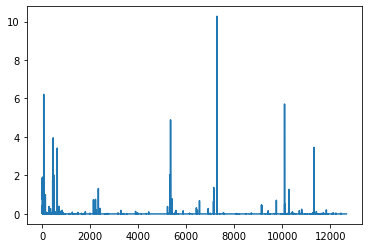

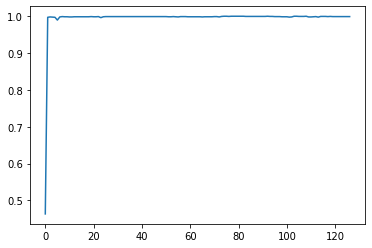

In [79]:
fig = plt.figure()
plt.plot(range(len(trainer.losses)), trainer.losses)
fig.show()

fig = plt.figure()
plt.plot(range(len(trainer.accuracies)), trainer.accuracies)
fig.show()

In [90]:
td = get_test_data()

In [91]:
test_forward = trainer.model(td[0])

In [94]:
class_pred = np.argmax(test_forward.detach().numpy(), axis=1)

In [95]:
td[1]

tensor([1., 0., 1.,  ..., 1., 0., 0.])

In [98]:
sum(td[1].numpy() == class_pred)

2113

In [99]:
len(class_pred)

2115